<img width="400" src="https://nomeroff.net.ua/images/logo/nomeroff_net.svg" alt="Nomeroff Net. Automatic numberplate recognition system" align="left"/>

## The example demonstrates license plate number detection.

Before runing this demo, please download models from [https://nomeroff.net.ua/models/](https://nomeroff.net.ua/models/) to **./models/** directory. 

In [1]:
# Import all necessary libraries.
import os
import cv2
import numpy as np
import sys
import json
import matplotlib.image as mpimg
from matplotlib import pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# change this property
NOMEROFF_NET_DIR = os.path.abspath('../')

# specify the path to Mask_RCNN if you placed it outside Nomeroff-net project
MASK_RCNN_DIR = os.path.join(NOMEROFF_NET_DIR, 'Mask_RCNN')

MASK_RCNN_LOG_DIR = os.path.join(NOMEROFF_NET_DIR, 'logs')
MASK_RCNN_MODEL_PATH = os.path.join(NOMEROFF_NET_DIR, "models/mask_rcnn_numberplate_0700.h5")
OPTIONS_MODEL_PATH =  os.path.join(NOMEROFF_NET_DIR, "models/numberplate_kz_options_2019_04_17.h5")

# If you use gpu version tensorflow please change model to gpu version named like *-gpu.pb
mode = "cpu"
OCR_NP_UKR_TEXT = os.path.join(NOMEROFF_NET_DIR, "models/anpr_ocr_ua_12-{}.h5".format(mode))
OCR_NP_EU_TEXT =  os.path.join(NOMEROFF_NET_DIR, "models/anpr_ocr_eu_2-{}.h5".format(mode))
OCR_NP_RU_TEXT =  os.path.join(NOMEROFF_NET_DIR, "models/anpr_ocr_ru_3-{}.h5".format(mode))
OCR_NP_KZ_TEXT =  os.path.join(NOMEROFF_NET_DIR, "models/anpr_ocr_kz_3-{}.h5".format(mode))

sys.path.append(NOMEROFF_NET_DIR)

Also you may use .pb models for options detectors or OCR detectors. 
More about conversion and preparing for inference withit https://github.com/ria-com/nomeroff-net/blob/master/examples/inference_convert.ipynb.

In [4]:
# Import license plate recognition tools.
from NomeroffNet import  filters, RectDetector, TextDetector, OptionsDetector, Detector, textPostprocessing, textPostprocessingAsync

# Initialize npdetector with default configuration file.
nnet = Detector(MASK_RCNN_DIR, MASK_RCNN_LOG_DIR)
nnet.loadModel(MASK_RCNN_MODEL_PATH)

rectDetector = RectDetector()

optionsDetector = OptionsDetector({
    "class_region": ["xx_unknown", "eu_ua_2015", "eu_ua_2004", "eu_ua_1995", "eu", "xx_transit", "ru", "kz"]
})
optionsDetector.load(OPTIONS_MODEL_PATH)

# Initialize text detector.
textDetector = TextDetector({
    "eu_ua_2004_2015": {
        "for_regions": ["eu_ua_2015", "eu_ua_2004"],
        "model_path": OCR_NP_UKR_TEXT
    },
    "eu": {
        "for_regions": ["eu", "eu_ua_1995"],
        "model_path": OCR_NP_EU_TEXT
    },
    "ru": {
        "for_regions": ["ru"],
        "model_path": OCR_NP_RU_TEXT
    },
    "kz": {
        "for_regions": ["kz"],
        "model_path": OCR_NP_KZ_TEXT
    }
})

Using TensorFlow backend.
W0418 11:22:16.474961 139761813550400 deprecation.py:237] From /usr/local/lib64/python3.6/site-packages/keras/backend/tensorflow_backend.py:4139: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0418 11:22:19.302768 139761813550400 deprecation.py:237] From /mnt/data/www/nomeroff-net/Mask_RCNN/mrcnn/model.py:341: The name tf.log is deprecated. Please use tf.math.log instead.

W0418 11:22:19.318030 139761813550400 deprecation.py:506] From /mnt/data/www/nomeroff-net/Mask_RCNN/mrcnn/model.py:423: calling crop_and_resize_v1 (from tensorflow.python.ops.image_ops_impl) with box_ind is deprecated and will be removed in a future version.
Instructions for updating:
box_ind is deprecated, use box_indices instead
W0418 11:22:19.588161 139761813550400 deprecation.py:237] From /mnt/data/www/nomeroff-net/Mask_RCNN/mrcnn/model.py:721: The name tf.sets.set_intersection is deprecated. Please use tf.sets.intersection instead.

W0418 11:22:19.5898

images/example1.jpeg


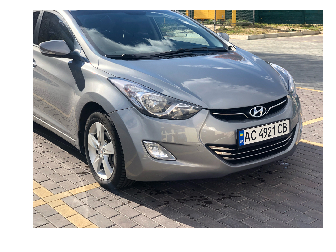

[[[1084.78613911  457.12993386]
  [1086.09244576  517.21827393]
  [ 876.12576469  571.94363898]
  [ 874.93349263  506.36909968]]]


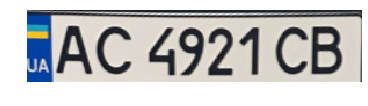

['eu_ua_2015']
['AC4921CB']
images/250030939.jpeg


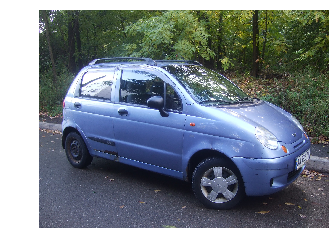

[[[1493.          758.69490109]
  [1493.          820.18393396]
  [1415.          882.58390751]
  [1415.          821.09487464]]]


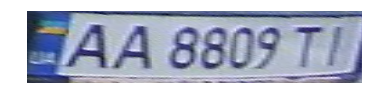

['eu_ua_2015']
['AA8809TI']
images/inx960x640.jpg


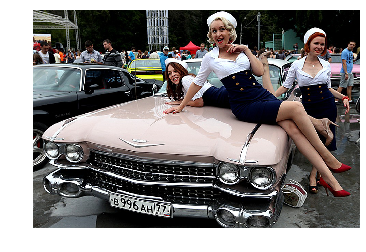

[[[402.52335291 568.97195982]
  [404.43626147 612.96889034]
  [226.         585.74983495]
  [226.         542.04468957]]]


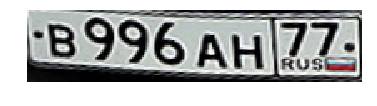

['ru']
['B996AH77']
images/example2.jpeg


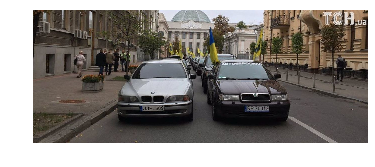

[[[948.         380.        ]
  [948.         404.        ]
  [851.         404.        ]
  [851.         380.        ]]

 [[530.86230469 380.        ]
  [530.86230469 402.34075218]
  [429.         400.9453897 ]
  [429.         380.        ]]]


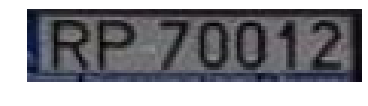

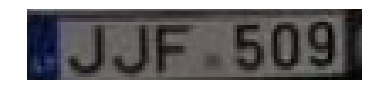

['eu', 'eu']
['RP70012', 'JJF509']
images/20717578-39-full.jpg


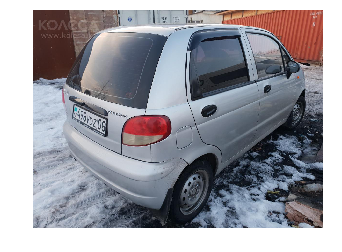

[[[167.37690918 390.51678919]
  [305.         452.50915894]
  [305.         515.42419492]
  [165.49606242 452.58460093]]]


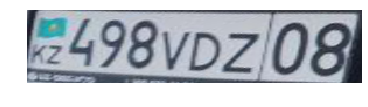

['kz']
['498VDZ08']


In [5]:
# Walking through the ./examples/images/ directory and checking each of the images for license plates.
rootDir = 'images/'

max_img_w = 1600
for dirName, subdirList, fileList in os.walk(rootDir):
    for fname in fileList:
        img_path = os.path.join(dirName, fname)
        print(img_path)
        img = mpimg.imread(img_path)
        plt.axis("off")
        plt.imshow(img)
        plt.show()
         
        # corect size for better speed
        img_w = img.shape[1]
        img_h = img.shape[0]
        img_w_r = 1
        img_h_r = 1
        if img_w > max_img_w:
            resized_img = cv2.resize(img, (max_img_w, int(max_img_w/img_w*img_h)))
            img_w_r = img_w/max_img_w
            img_h_r = img_h/(max_img_w/img_w*img_h)
        else:
            resized_img = img

        NP = nnet.detect([resized_img]) 
        
        # Generate image mask.
        cv_img_masks = await filters.cv_img_mask_async(NP)
            
        # Detect points.
        arrPoints = await rectDetector.detectAsync(cv_img_masks, outboundHeightOffset=3-img_w_r)
        print(arrPoints)
        arrPoints[..., 1:2] = arrPoints[..., 1:2]*img_h_r
        arrPoints[..., 0:1] = arrPoints[..., 0:1]*img_w_r
        
        # cut zones
        zones = await rectDetector.get_cv_zonesBGR_async(img, arrPoints)
        toShowZones = await rectDetector.get_cv_zonesRGB_async(img, arrPoints)
        for zone, points in zip(toShowZones, arrPoints):
            plt.axis("off")
            plt.imshow(zone)
            plt.show()
    
        # find standart
        regionIds, stateIds = optionsDetector.predict(zones)
        regionNames = optionsDetector.getRegionLabels(regionIds)
        print(regionNames)

        # find text with postprocessing by standart  
        textArr = textDetector.predict(zones, regionNames)
        textArr = await textPostprocessingAsync(textArr, regionNames)
        print(textArr)